# Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2,3,4,5"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf
import datetime
import random
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import img_to_array, load_img
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, Dropout, Flatten, Dense
from tensorflow.keras.layers import BatchNormalization
from sklearn.metrics import auc, precision_recall_curve, average_precision_score, confusion_matrix, roc_curve, roc_auc_score
from tensorflow.keras.metrics import AUC
from keras.preprocessing import image
import keras_tuner as kt
from keras_tuner import HyperParameters, Tuner
from keras_tuner import Objective
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.densenet import DenseNet121
from matplotlib.cm import ScalarMappable

%load_ext tensorboard

In [ ]:
# !rm -rf ./logs/

# Mirrored Strategy

In [2]:
# Define the MirroredStrategy
mirrored_strategy = tf.distribute.MirroredStrategy()
num_gpus = mirrored_strategy.num_replicas_in_sync
num_gpus

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')


4

# Defining Variables

In [3]:
approach = "uignore_ht_aug"

source_path = '.'
# all_pathology = ['Atelectasis','Cardiomegaly','Consolidation','Edema','Pleural Effusion']
all_pathology = ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Pleural Effusion',
                   'No Finding', 'Enlarged Cardiomediastinum', 'Lung Opacity', 'Lung Lesion', 
                   'Pneumonia', 'Pneumothorax', 'Pleural Other', 'Fracture', 'Support Devices']

competition_pathology = ['Atelectasis','Cardiomegaly','Consolidation','Edema','Pleural Effusion']

local_batch = 16
batch_size = local_batch*num_gpus
AUTOTUNE = tf.data.AUTOTUNE
augmentation_setting = True

iterations = 4800
checkpoint_start = int(iterations/num_gpus)
top_rank = 20


# Loading Dataset

In [4]:
source_path = '.'
train_directory = os.path.join(source_path, 'CheXpert-v1.0/train')
validation_directory = os.path.join(source_path, 'CheXpert-v1.0/valid')
test_directory = os.path.join(source_path, 'CheXpert-v1.0/test')

print(f"There are {len(os.listdir(train_directory))}")
print(f"There are {len(os.listdir(validation_directory))}")
print(f"There are {len(os.listdir(test_directory))}")

There are 64540
There are 200
There are 500


In [5]:
# Load train and valid labels
train_df = pd.read_csv(os.path.join(source_path, 'CheXpert-v1.0/train.csv'))
valid_df = pd.read_csv(os.path.join(source_path, 'CheXpert-v1.0/valid.csv'))
test_df = pd.read_csv(os.path.join(source_path, 'CheXpert-v1.0/test.csv'))

# Creating DataFrames

In [6]:
train_df = train_df[['Path','Atelectasis','Cardiomegaly','Consolidation','Edema','Pleural Effusion',
                     'No Finding','Enlarged Cardiomediastinum', 'Lung Opacity','Lung Lesion','Pneumonia',
                     'Pneumothorax', 'Pleural Other', 'Fracture','Support Devices']]
train_df = train_df.fillna(0)

In [7]:
# Counting number of uncertain findings in each pathology

print(f"Cardiomegaly -1: {len(train_df[train_df['Cardiomegaly'] == -1])}")
print(f"Edema -1: {len(train_df[train_df['Edema'] == -1])}")
print(f"Consolodation -1: {len(train_df[train_df['Consolidation'] == -1])}")
print(f"Atelectasis -1: {len(train_df[train_df['Atelectasis'] == -1])}")
print(f"Pleural -1: {len(train_df[train_df['Pleural Effusion'] == -1])}")

Cardiomegaly -1: 8087
Edema -1: 12984
Consolodation -1: 27742
Atelectasis -1: 33739
Pleural -1: 11628


In [8]:
# UIgnore - Ignore rows where there is at least one uncertain reading
mask = (train_df != -1.0).all(axis=1)

# Apply the mask to filter the DataFrame
train_df_filtered = train_df[mask]

# Keeping the uncertain labels
train_df_uncertain = train_df[mask == False]

In [9]:
valid_df = valid_df[['Path','Atelectasis','Cardiomegaly','Consolidation','Edema','Pleural Effusion',
                     'No Finding','Enlarged Cardiomediastinum', 'Lung Opacity','Lung Lesion','Pneumonia',
                     'Pneumothorax', 'Pleural Other', 'Fracture','Support Devices']]

In [10]:
test_df = test_df[['Path','Atelectasis','Cardiomegaly','Consolidation','Edema','Pleural Effusion',
                     'No Finding','Enlarged Cardiomediastinum', 'Lung Opacity','Lung Lesion','Pneumonia',
                     'Pneumothorax', 'Pleural Other', 'Fracture','Support Devices']]

# Image Paths

In [11]:
#Load image paths

train_image_paths = [source_path + '/' + path for path in train_df_filtered['Path']]
train_image_uncertain_paths = [source_path + '/' + path for path in train_df_uncertain['Path']]
valid_image_paths = [source_path + '/' + path for path in valid_df['Path']]
test_image_paths = [source_path + '/' + path for path in test_df['Path']]

In [12]:
# Create TensorFlow tensors from image paths
train_image_paths = tf.constant(train_image_paths)
train_image_uncertain_paths = tf.constant(train_image_uncertain_paths)
valid_image_paths = tf.constant(valid_image_paths)
test_image_paths = tf.constant(test_image_paths)

# Train and Valid Labels

In [13]:
# Dropping path as no longer required

train_df = train_df_filtered.drop(['Path'], axis=1)
train_df_uncertain = train_df_uncertain.drop(['Path'], axis=1)
valid_df = valid_df.drop(['Path'], axis=1)
test_df = test_df.drop(['Path'], axis=1)

In [14]:
# Convert to array

train_labels = np.array(train_df)
train_labels_uncertain = np.array(train_df_uncertain)
valid_labels = np.array(valid_df)
test_labels = np.array(test_df)

In [ ]:
# print(train_labels.shape)
# print(train_labels_uncertain.shape)
# print(valid_labels.shape)
# print(test_labels.shape)

# Image Processing

In [15]:
# Define a custom preprocessing function
def preprocess_image(image_path, label):
    # Read the image file
    image = tf.io.read_file(image_path)
    # Decode the image from bytes to a tensor
    image = tf.image.decode_jpeg(image, channels=3)
    # Normalize pixel values to be in the range [0, 1]
    image = tf.cast(image, tf.float32) / 255.0
    return image, label


# Prepare the data pipeline by setting batch size & buffer size using tf.data 

In [16]:
# Create TensorFlow datasets
train_ds = tf.data.Dataset.from_tensor_slices((train_image_paths, train_labels))
valid_ds = tf.data.Dataset.from_tensor_slices((valid_image_paths, valid_labels))
train_ds_uncertain = tf.data.Dataset.from_tensor_slices((train_image_uncertain_paths, train_labels_uncertain))
test_ds = tf.data.Dataset.from_tensor_slices((test_image_paths, test_labels))

In [17]:
# Apply preprocessing function to the datasets
train_ds = train_ds.map(preprocess_image, num_parallel_calls=AUTOTUNE)
valid_ds = valid_ds.map(preprocess_image, num_parallel_calls=AUTOTUNE)
train_ds_uncertain = train_ds_uncertain.map(preprocess_image, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.map(preprocess_image, num_parallel_calls=AUTOTUNE)

# Visualize Sample Image

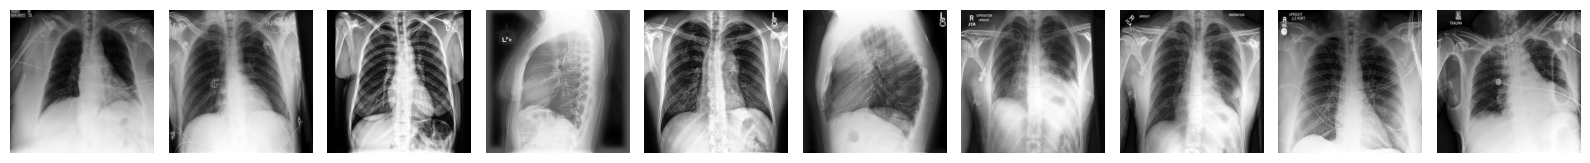

In [18]:
# Plot a sample of 10 original images
fig, axes = plt.subplots(1, 10, figsize=(16, 15))  # Adjust the figsize as needed
axes = axes.flatten()

for i, (image, label) in enumerate(train_ds.take(10)):
    ax = axes[i]
    ax.imshow(image.numpy())  # Select the first image from the batch
    ax.set_axis_off()

plt.tight_layout()
plt.show()

# Augementation

In [19]:
global global_flip, global_rotation, global_height_zoom, global_width_zoom, global_height_translation, global_width_translation

# Default values
global_flip = "horizontal"
global_rotation = 0.2
global_height_zoom = -0.1
global_width_zoom = -0.1
global_height_translation = 0.2
global_width_translation = 0.2

In [20]:
def prepare(ds, shuffle=False, augment=False):
    if shuffle:
        ds = ds.shuffle(1000)

    ds = ds.batch(batch_size)
    ds = ds.cache()

    if augment:
        data_augmentation = tf.keras.Sequential([
            layers.RandomFlip(global_flip),
            layers.RandomRotation(global_rotation),
            layers.RandomZoom(
                height_factor=(global_height_zoom, global_height_zoom),
                width_factor=(global_width_zoom, global_width_zoom)),
            layers.RandomTranslation(height_factor=global_height_translation, width_factor=global_width_translation),
        ])
        ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=AUTOTUNE)

    return ds.prefetch(buffer_size=AUTOTUNE)


In [21]:
train_ds = prepare(train_ds, shuffle=True, augment=augmentation_setting)
train_ds_uncertain = prepare(train_ds_uncertain, shuffle=True, augment=augmentation_setting)
valid_ds = prepare(valid_ds)
test_ds = prepare(test_ds)

# Visualize Augmented Image

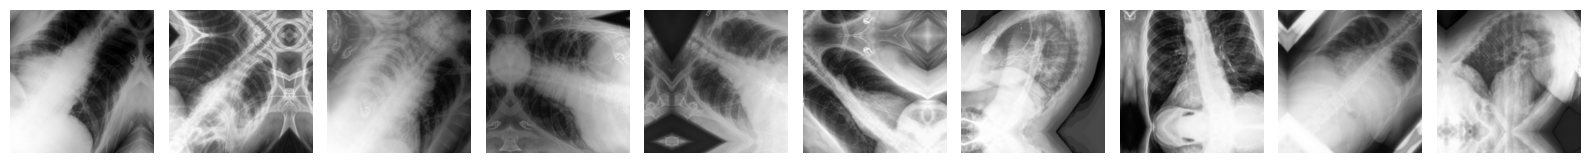

In [22]:
# Define a function to plot sample images
def plot_sample_images(dataset, num_samples=10):
    # Create an iterator for the dataset
    iterator = iter(dataset)

    # Get the next batch of images and labels
    sample_images, sample_labels = next(iterator)

    # Plot the sample images
    fig, axes = plt.subplots(1, num_samples, figsize=(16, 15))
    axes = axes.flatten()

    for i in range(num_samples):
        img = sample_images[i]
        ax = axes[i]
        ax.imshow(img.numpy())  # Convert TensorFlow tensor to NumPy array for plotting
        ax.set_axis_off()

    plt.tight_layout()
    plt.show()

# Visualize sample images from the training dataset
plot_sample_images(train_ds, num_samples=10)

# Hyperparameter Tuning

In [23]:
def create_model(hp, image_size=320, load_previous_weights=False, freeze_cnn=False):
    with mirrored_strategy.scope():
        
        global global_flip, global_rotation, global_height_zoom, global_width_zoom, global_height_translation, global_width_translation

        # Tuning augmentation parameters
        global_flip = hp.Choice('flip', values=["horizontal", "vertical", "none"])
        global_rotation = hp.Float('rotation', min_value=0.0, max_value=0.5, step=0.1)
        global_height_zoom = hp.Float('height_zoom', min_value=-0.2, max_value=0.2, step=0.05)
        global_width_zoom = hp.Float('width_zoom', min_value=-0.2, max_value=0.2, step=0.05)
        global_height_translation = hp.Float('height_translation', min_value=-0.3, max_value=0.3, step=0.1)
        global_width_translation = hp.Float('width_translation', min_value=-0.3, max_value=0.3, step=0.1)

        base_model = DenseNet121(include_top=False, input_shape=(image_size, image_size, 3), weights='imagenet')

        # Add a global spatial average pooling layer
        x = base_model.output
        x = GlobalAveragePooling2D()(x)

        # First dense layer with tunable units and dropout
        dense_1_units = hp.Int('dense_1_units', min_value=512, max_value=3072, step=512)
        x = Dense(dense_1_units, activation='relu')(x)
        x = BatchNormalization()(x)
        dropout_1 = hp.Float('dropout_1', min_value=0.0, max_value=0.5, step=0.1)
        x = Dropout(dropout_1)(x)

        # Second dense layer with tunable units and dropout
        dense_2_units = hp.Int('dense_2_units', min_value=256, max_value=1536, step=256)
        x = Dense(dense_2_units, activation='relu')(x)
        x = BatchNormalization()(x)
        dropout_2 = hp.Float('dropout_2', min_value=0.0, max_value=0.5, step=0.1)
        x = Dropout(dropout_2)(x)

        # Define output
        output = Dense(units=len(all_pathology), activation='sigmoid')(x)

        # Create the model
        model = Model(inputs=base_model.input, outputs=output)

        # Recover previously trained weights
        if load_previous_weights:
            try:
                model.load_weights(f'./logs/fit/{approach}/run_{run+1}/final_model.h5')
                print('Weights successfully loaded')
            except:
                print('Weights not loaded')

        # Freeze CNN layers if specified
        if freeze_cnn:
            for layer in base_model.layers:
                layer.trainable = False

        # Tunable learning rate
        learning_rate = hp.Float('learning_rate', min_value=1e-5, max_value=1e-3, sampling='LOG')

        # Compile the model
        model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss='binary_crossentropy',
              metrics=['binary_accuracy', tf.keras.metrics.AUC(multi_label=True, num_labels=14)])

    return model


In [24]:
tuner = kt.Hyperband(
    create_model,
    objective=Objective('val_auc', direction ="max"),
    max_epochs=4,
    factor=5,
    hyperband_iterations=1, 
    directory='kt_hyperband',
    project_name=f'{approach}_tuning'
)

Reloading Tuner from kt_hyperband/uignore_ht_aug_tuning/tuner0.json


In [25]:
# Create a callback to stop training early after reaching a certain value for the validation loss.
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)

In [26]:
# Start the hyperparameter tuning process
tuner.search(train_ds, epochs=4, validation_data=(valid_ds), callbacks=[stop_early], verbose = 2)

In [27]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Printing the optimal values for both model and augmentation parameters
print(f"""
The hyperparameter search is complete. Here are the optimal values:

Model Parameters:
- Dense1 Units: {best_hps.get('dense_1_units')}
- Dense2 Units: {best_hps.get('dense_2_units')}
- Dropout 1: {best_hps.get('dropout_1')}
- Dropout 2: {best_hps.get('dropout_2')}
- Learning Rate: {best_hps.get('learning_rate')}

Augmentation Parameters:
- Flip: {best_hps.get('flip')}
- Rotation: {best_hps.get('rotation')}
- Height Zoom: {best_hps.get('height_zoom')}
- Width Zoom: {best_hps.get('width_zoom')}
- Height Translation: {best_hps.get('height_translation')}
- Width Translation: {best_hps.get('width_translation')}
""")


The hyperparameter search is complete. Here are the optimal values:

Model Parameters:
- Dense1 Units: 512
- Dense2 Units: 512
- Dropout 1: 0.30000000000000004
- Dropout 2: 0.4
- Learning Rate: 7.121274437576637e-05

Augmentation Parameters:
- Flip: none
- Rotation: 0.0
- Height Zoom: 0.15000000000000002
- Width Zoom: 0.15000000000000002
- Height Translation: 5.551115123125783e-17
- Width Translation: 0.2



# Build the Model

# Train the Model

In [28]:
import time

def create_callbacks(run_num):
    log_dir = f"logs/fit/{approach}/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

    checkpoint_dir = f"logs/fit/{approach}/run_{run_num}"

    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)

    # SaveCheckpointCallback class definition
    class SaveCheckpointCallback(tf.keras.callbacks.Callback):
        def __init__(self, checkpoint_dir, save_interval):
            super(SaveCheckpointCallback, self).__init__()
            self.checkpoint_dir = checkpoint_dir
            self.save_interval = save_interval
            self.iteration = 0

        def on_batch_end(self, batch, logs=None):
            self.iteration += 1
            if self.iteration % self.save_interval == 0:
                model_checkpoint = os.path.join(self.checkpoint_dir, f"model_checkpoint_{self.iteration}.h5")
                self.model.save(model_checkpoint)
                print(f"Saved checkpoint at iteration {self.iteration} to {model_checkpoint}")

    save_interval = int(iterations/num_gpus) 
    checkpoint_callback = SaveCheckpointCallback(checkpoint_dir, save_interval)
    
    return [checkpoint_callback, tensorboard_callback]

In [29]:
trained_models = []

def train(num_runs, train_ds, valid_ds, best_hps, best_epoch):

    for run in range(num_runs):
        print(f"Run {run + 1} of {num_runs}")

        # Clear previous session for a fresh start
        tf.keras.backend.clear_session()
        
        # Build the model with the best hyperparameters
        model = tuner.hypermodel.build(best_hps)

        # Create callbacks for the current run
        callbacks = create_callbacks(run+1)

        # Train the model
        start = time.time()
        history = model.fit(
            train_ds, 
            epochs=best_epoch, 
            validation_data=valid_ds, 
            batch_size=batch_size, 
            callbacks=callbacks, 
            verbose=2
        )
        print("Total time for run", run + 1, ": ", time.time() - start, "seconds")
        
        # Save the trained model
        final_model_path = f"logs/fit/{approach}/run_{run+1}/final_model.h5"
        model.save(final_model_path)
        print(f"Final model saved for run {run+1} at {final_model_path}")
        
        # Append the trained model to the list
        trained_models.append(model)

    return trained_models

# Number of runs for training
num_runs = 3
# Train the model 3 times with the best hyperparameters
training = train(num_runs, train_ds, valid_ds, best_hps, best_epoch=4)

Run 1 of 3
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tens

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Saved checkpoint at iteration 1200 to logs/fit/uignore_ht_aug/run_1/model_checkpoint_1200.h5
2162/2162 - 801s - loss: 0.5952 - binary_accuracy: 0.7134 - auc: 0.5797 - val_loss: 0.6150 - val_binary_accuracy: 0.8034 - val_auc: 0.5211 - 801s/epoch - 371ms/step
Epoch 2/4
Saved checkpoint at iteration 2400 to logs/fit/uignore_ht_aug/run_1/model_checkpoint_2400.h5
Saved checkpoint at iteration 3600 to logs/fit/uignore_ht_aug/run_1/model_checkpoint_3600.h5
2162/2162 - 575s - loss: 0.3636 - binary_accuracy: 0.8524 - auc: 0.6482 - val_loss: 0.7817 - val_binary_accuracy: 0.8168 - val_auc: 0.5586 - 575s/epoch - 266ms/step
Epoch 3/4
Saved checkpoint at iteration 4800 to logs/fit/uignore_ht_aug/run_1/model_checkpoint_4800.h5
Saved checkpoint at iteration 6000 to logs/fit/uignore_ht_aug/run_1/model_checkpoint_6000.h5
2162/2162 - 527s - loss: 0.3399 - binary_accuracy: 0.8615 - auc: 0.6877 - val_loss: 0.4807 - val_binary_accuracy: 0.8135 - val_auc: 0.6604 - 527s/epoch - 244ms/step
Epoch 4/4
Saved chec

In [ ]:
%tensorboard --logdir logs --port 8896

# Model Evaluate at Every Iterations

In [30]:
# Initialize a list to store checkpoint paths for each run
checkpoint_paths_list = []

for run in range(num_runs):
    checkpoint_paths = []  

    # Collect checkpoint paths
    for iteration in range(checkpoint_start, 8401, checkpoint_start):  
        checkpoint_path = f"logs/fit/{approach}/run_{run + 1}/model_checkpoint_{iteration}.h5"
        checkpoint_paths.append(checkpoint_path)

    checkpoint_paths_list.append(checkpoint_paths)


In [31]:
all_valid_images = []
all_valid_labels = []

for images, labels in valid_ds:
    all_valid_images.append(images.numpy())
    all_valid_labels.append(labels.numpy())

# Concatenate all images and labels into two large numpy arrays
all_valid_images = np.concatenate(all_valid_images, axis=0)
all_valid_labels = np.concatenate(all_valid_labels, axis=0)
print(f"all_valid_images shape: {all_valid_images.shape}")
print(f"all_valid_labels shape: {all_valid_labels.shape}")

all_valid_images shape: (234, 320, 320, 3)
all_valid_labels shape: (234, 14)


In [32]:
# Initialize a list to store predictions for each checkpoint
all_predictions = []

# Iterate through the collected checkpoint paths and corresponding trained model
for model, checkpoint_paths in zip(trained_models, checkpoint_paths_list):
    predictions = []  # Store predictions for the current run

    # Load each checkpoint and predict on the validation set
    for checkpoint_path in checkpoint_paths:
        model.load_weights(checkpoint_path)

        # Predict on the validation set
        checkpoint_predictions = model.predict(all_valid_images)
        predictions.append(checkpoint_predictions)

    all_predictions.append(predictions)
all_predictions = np.array(all_predictions)

print(f"all pred shape: {all_predictions.shape}")

8/8 [==============================] - 1s 42ms/step
all pred shape: (3, 7, 234, 14)


In [33]:
top_rank = 10

average_auroc_list = []
num_pathologies = 5
iteration_auroc = [] 

for checkpoint_predictions in all_predictions:

    for checkpoint_index, checkpoint_prediction in enumerate(checkpoint_predictions):
        checkpoint_auroc_scores = []  # Store AUROC scores for the current model

        for pathology_index in range(num_pathologies):
            true_labels = all_valid_labels[:, pathology_index]
            auroc = roc_auc_score(true_labels, checkpoint_prediction[:, pathology_index])
            checkpoint_auroc_scores.append(auroc)

        iteration_auroc.append(checkpoint_auroc_scores)

# Convert iteration_auroc to array
iteration_auroc = np.array(iteration_auroc)

print(f"iteration_auroc_shape: {iteration_auroc.shape}")

# Calculate the average AUROC across 5 pathologies
average_auroc = np.mean(iteration_auroc, axis = 1)

# Calculate the indices that would sort the average AUROC list in descending order
sorted_indices = np.argsort(average_auroc)[::-1]

# Get the top top_rank indices
top_indices = sorted_indices[:top_rank]

# Initialize a list to store the corresponding checkpoint_auroc_scores
best_checkpoint_auroc_scores = []

# Extract the checkpoint_auroc_scores for top_rank
for index in top_indices:
    best_checkpoint_auroc_scores.append(iteration_auroc[index])

best_checkpoint_auroc_scores = np.array(best_checkpoint_auroc_scores)

# Compute AUROC, Standard Deviation, and Confidence Intervals
auroc_pathology = np.mean(best_checkpoint_auroc_scores, axis=0)
std_dev_pathology = np.std(best_checkpoint_auroc_scores, axis=0)
confidence_intervals = [(auroc - 1.96 * std, auroc + 1.96 * std) for auroc, std in zip(auroc_pathology, std_dev_pathology)]

# Header
print(f"{'Pathology':<15} {'Average AUROC':<15} {'Standard Error':<17} {'95% Confidence Interval'}")

# Separator
print('-' * 65)

# Table content
for i, pathology in enumerate(competition_pathology):
    standard_error = std_dev_pathology[i] / np.sqrt(len(best_checkpoint_auroc_scores))
    lower_bound, upper_bound = confidence_intervals[i]
    print(f"{pathology:<15} {auroc_pathology[i]:<15.4f} {standard_error:<17.4f} ({lower_bound:.4f}, {upper_bound:.4f})")

# Overall AUROC
overall_ave = np.mean(average_auroc[top_indices])
print(f"\nOverall average AUROC (from top {top_rank} models/checkpoints): {overall_ave:.4f}")

iteration_auroc_shape: (21, 5)
Pathology       Average AUROC   Standard Error    95% Confidence Interval
-----------------------------------------------------------------
Atelectasis     0.7840          0.0075            (0.7378, 0.8302)
Cardiomegaly    0.7796          0.0063            (0.7406, 0.8185)
Consolidation   0.8879          0.0062            (0.8496, 0.9262)
Edema           0.8748          0.0056            (0.8401, 0.9095)
Pleural Effusion 0.8912          0.0036            (0.8686, 0.9137)

Overall average AUROC (from top 10 models/checkpoints): 0.8435


# Performance on Test Set

In [34]:
# Getting test images and labels:
all_test_images = []
all_test_labels = []

for images, labels in test_ds:
    all_test_images.append(images.numpy())
    all_test_labels.append(labels.numpy())

# Concatenate all images and labels into two large numpy arrays
all_test_images = np.concatenate(all_test_images, axis=0)
all_test_labels = np.concatenate(all_test_labels, axis=0)
print(f"all_test_images shape: {all_test_images.shape}")
print(f"all_test_labels shape: {all_test_labels.shape}")

all_test_images shape: (668, 320, 320, 3)
all_test_labels shape: (668, 14)


In [35]:
# Calculate the number of checkpoints per model
num_checkpoints_per_model = len(checkpoint_paths_list[0])

# Determine the best model and checkpoint indices based on the best_model_index
best_model_index = top_indices[0] // num_checkpoints_per_model
best_checkpoint_index = top_indices[0] % num_checkpoints_per_model

# Reference the predictions of the best model and checkpoint
best_model_predictions = all_predictions[best_model_index, best_checkpoint_index]

# Load the best checkpoint weights into the corresponding model
best_model = trained_models[best_model_index]
best_checkpoint_path = checkpoint_paths_list[best_model_index][best_checkpoint_index]
best_model.load_weights(best_checkpoint_path)

In [36]:
# Predict on the test set using the best model
test_predictions = best_model.predict(all_test_images)
print(f"test_predictions shape: {test_predictions.shape}") 

# Directory where the figures will be saved
save_dir = f"test_performance/{approach}"
os.makedirs(save_dir, exist_ok=True)

# 2. Calculate and Plot ROC for each pathology
for i in range(num_pathologies):
    fpr, tpr, _ = roc_curve(all_test_labels[:, i], test_predictions[:, i])
    auc = roc_auc_score(all_test_labels[:, i], test_predictions[:, i])
    plt.figure()
    plt.plot(fpr, tpr, label=f"{competition_pathology[i]} (AUC = {auc:.2f})")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve for {competition_pathology[i]}")
    plt.legend(loc="lower right")
    plt.tight_layout()

    # Save ROC curve
    roc_filename = f"{competition_pathology[i]}_auroc.png"
    plt.savefig(os.path.join(save_dir, roc_filename))
    plt.close()

# 2. Calculate and Plot PR curve for each pathology
for i in range(num_pathologies):
    precision, recall, _ = precision_recall_curve(all_test_labels[:, i], test_predictions[:, i])
    average_precision = average_precision_score(all_test_labels[:, i], test_predictions[:, i])
    plt.figure()
    plt.plot(recall, precision, label=f"{competition_pathology[i]} (AP = {average_precision:.2f})")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"Precision-Recall Curve for {competition_pathology[i]}")
    plt.legend(loc="upper right")
    plt.tight_layout()

    # Save PR curve
    pr_filename = f"{competition_pathology[i]}_pr.png"
    plt.savefig(os.path.join(save_dir, pr_filename))
    plt.close()

21/21 [==============================] - 2s 62ms/step
test_predictions shape: (668, 14)


## Explaining the Prediction

In [37]:
def true_labels(image_index, all_test_labels, all_pathology):
    
    labels = all_test_labels[image_index]

    print(f"True labels for image {image_index}:")
    for i, label in enumerate(labels):
        if label == 1:
            print(all_pathology[i])


In [38]:
def top5_predictions(image, best_model, all_pathology):
    
    # Get the prediction for the image
    predictions = best_model.predict(np.array([image]), verbose=0)[0]

    # Pair each probability with the corresponding pathology and sort them
    probabilities_and_pathologies = [(p, all_pathology[i]) for i, p in enumerate(predictions)]
    top_5_predictions = sorted(probabilities_and_pathologies, key=lambda x: x[0], reverse=True)[:5]

    # Print the top 5 predictions
    print("Top 5 Predictions:")
    print("{:<25} {}".format("Pathology", "Probability"))
    for probability, pathology in top_5_predictions:
        print("{:<25} {:.2f}".format(pathology, probability))

## LIME

In [39]:
def model_predict(images, best_model):
    return best_model.predict(images, verbose=0)

In [40]:
from lime import lime_image
from skimage.segmentation import mark_boundaries

def lime(image, image_index, model_predict, best_model, all_pathology, approach, top_labels=5, num_samples=1000):
   
    if not os.path.exists('lime'):
        os.makedirs('lime')
    
    # Instantiate the LIME image explainer
    explainer = lime_image.LimeImageExplainer()

    # Explain instance with LIME
    explanation = explainer.explain_instance(
        image,
        lambda x: model_predict(x, best_model),
        top_labels=top_labels,
        hide_color=0,
        num_samples=num_samples
    )

    # Predictions for the image
    predictions = model_predict(np.array([image]), best_model)[0]
    probabilities_and_pathologies = [(p, all_pathology[i]) for i, p in enumerate(predictions)]
    top_predictions = sorted(probabilities_and_pathologies, key=lambda x: x[0], reverse=True)[:top_labels]

    # Visualize the explanation for each of the top labels
    for probability, pathology in top_predictions:
        model_label_index = all_pathology.index(pathology)
        if model_label_index in explanation.top_labels:
            temp, mask = explanation.get_image_and_mask(model_label_index,
                                                        positive_only=False,
                                                        num_features=10,
                                                        hide_rest=False)
            plt.figure(figsize=(5, 5))
            plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
            plt.title(f"LIME Explanation for {pathology} with probability {probability:.2f}")
            plt.savefig(f'lime/{approach}_{image_index}_{pathology}.png')
            plt.show()
    
        else:
            print(f"No LIME explanation for {pathology}")

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Grad CAM

In [41]:
import matplotlib
from matplotlib import cm
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.utils.scores import CategoricalScore
from matplotlib.cm import jet
from matplotlib.colors import Normalize
import tensorflow.keras.utils as keras_utils

In [42]:
last_conv_layer_name = 'conv5_block16_concat' 

In [43]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations of the last conv layer
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0]).numpy()
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by 'how important this channel is' with regard to the top predicted class
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purposes, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy(), preds[0], pred_index


In [44]:
def display_heatmap(heatmap, predictions, all_pathology, top_n=5):
    
    # Display heatmap
    plt.matshow(heatmap)
    plt.show()

    # Print the top predictions
    print("Top Predictions from Grad-CAM:")
    print("{:<25} {}".format("Pathology", "Probability"))

    # Sort the predictions and get the top ones
    sorted_predictions = sorted(zip(all_pathology, predictions.numpy()), key=lambda x: x[1], reverse=True)

    for pathology, probability in sorted_predictions[:top_n]:
        print("{:<25} {:.2f}".format(pathology, probability))


In [45]:
def display_gradcam(img, image_index, heatmap, top_pred_index, cam_path=f"{approach}", alpha=0.4):
    cam_path = f"cam/{approach}_{image_index}.jpg"

    cam_dir = os.path.dirname(cam_path)
    if not os.path.exists(cam_dir):
        os.makedirs(cam_dir)
    
    # Ensure the original image is in the correct format
    img = np.uint8(img * 255) if np.max(img) <= 1 else np.uint8(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = matplotlib.colormaps['jet']

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras_utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras_utils.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras_utils.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM with a colorbar
    fig, ax = plt.subplots()
    im = ax.imshow(superimposed_img)
    ax.axis('off')  # Turn off axis

    # Create a ScalarMappable with the colormap used for the heatmap
    norm = Normalize(vmin=0, vmax=255)
    sm = cm.ScalarMappable(cmap=jet, norm=norm)
    sm.set_array([])  # Set the array to an empty list

    # Add the colorbar to the figure
    plt.colorbar(sm, ax=ax, orientation='vertical', fraction=0.046, pad=0.04)
    
    # Determine the top prediction index
    top_pred_index = np.argmax(predictions)

    # Get the pathology name using the top prediction index
    pathology_name = all_pathology[top_pred_index]
    plt.title(f"Grad CAM for {pathology_name}")

    plt.show()

## Saliency Map

In [46]:
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.utils import normalize

In [47]:
def saliency_map(image, image_index, best_model, all_pathology, approach):
    
    if not os.path.exists('saliency'):
        os.makedirs('saliency')
    
    # Predict the class
    predictions = best_model.predict(np.array([image]), verbose=0)
    top_pred_class = np.argmax(predictions)

    # Create Saliency object
    saliency = Saliency(best_model, clone=False)

    # Use the top predicted class as the score
    score = CategoricalScore([top_pred_class])

    # Generate saliency map
    saliency_map = saliency(score, img_array)
    saliency_map = normalize(saliency_map)

    # Generate saliency map
    saliency_map = saliency(score, np.array([image]))
    saliency_map = normalize(saliency_map)

    # Reshape the saliency map for display
    saliency_map = np.squeeze(saliency_map)

    # Display the saliency map
    fig, ax = plt.subplots(figsize=(6, 4))
    img_display = ax.imshow(saliency_map, cmap='jet')
    ax.axis('off')  # Turn off axis

    # Create a colorbar
    norm = Normalize(vmin=saliency_map.min(), vmax=saliency_map.max())
    sm = ScalarMappable(cmap='jet', norm=norm)
    sm.set_array([])

    # Add the colorbar to the figure
    fig.colorbar(sm, ax=ax, orientation='vertical', fraction=0.046, pad=0.04)
    plt.title(f"Saliency Map for {all_pathology[top_pred_class]}")
    plt.savefig(f'saliency/{image_index}_{approach}_{all_pathology[top_pred_class]}.png')
    plt.show()

## Smooth Grad

In [48]:
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

def smooth_grad(image, image_index, best_model, all_pathology, approach, smooth_samples=100):
    
    if not os.path.exists('smoothgrad'):
        os.makedirs('smoothgrad')
    
    # Predict the class
    predictions = best_model.predict(np.array([image]), verbose=0)
    top_pred_class = np.argmax(predictions)
    
    # Use the top predicted class as the score
    score = CategoricalScore([top_pred_class])

    saliency = Saliency(best_model)
    saliency_map = saliency(score, img_array, smooth_samples=50)
    saliency_map = normalize(saliency_map)

    # Remove the batch dimension and display the saliency map
    saliency_map = saliency_map[0]

    fig, ax = plt.subplots(figsize=(6, 4))

    # Display the saliency map
    img_display = ax.imshow(saliency_map, cmap='jet')
    ax.axis('off')  # Turn off axis

    # Create a colorbar
    norm = Normalize(vmin=saliency_map.min(), vmax=saliency_map.max())
    sm = ScalarMappable(cmap='jet', norm=norm)
    sm.set_array([]) 

    # Add the colorbar to the figure
    fig.colorbar(sm, ax=ax, orientation='vertical', fraction=0.046, pad=0.04)
    plt.title(f"Smooth Grad for {all_pathology[top_pred_class]}")
    plt.savefig(f'smoothgrad/{image_index}_{approach}_{all_pathology[top_pred_class]}.png')
    plt.show()


## Image and XAI Results

Found an image with Atelectasis as the top prediction at index: 581



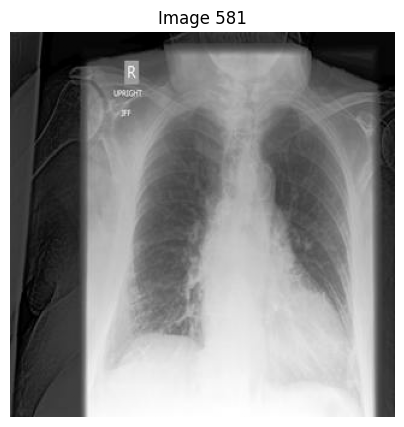

True labels for image 581:
Cardiomegaly
Enlarged Cardiomediastinum

Top 5 Predictions:
Atelectasis               0.24
Lung Opacity              0.23
Pleural Effusion          0.19
Edema                     0.19
No Finding                0.18


In [50]:
def find_image_with_top_prediction_pathname(all_test_images, all_test_labels, all_pathology, best_model, pathname):
    for index, image in enumerate(all_test_images):
        # Get the top 5 predictions for the current image
        predictions = best_model.predict(np.array([image]), verbose=0)[0]
        probabilities_and_pathologies = [(p, all_pathology[i]) for i, p in enumerate(predictions)]
        top_5_predictions = sorted(probabilities_and_pathologies, key=lambda x: x[0], reverse=True)[:5]

        # Check if the top prediction is pathname
        if top_5_predictions[0][1] == pathname:
            print(f"Found an image with {pathname} as the top prediction at index: {index}\n")

            # Display the image
            plt.figure(figsize=(5,5))
            plt.imshow(image, cmap='gray')
            plt.title(f"Image {index}")
            plt.axis('off')  # Hide the axis
            plt.show()

            # Print true labels
            true_labels(index, all_test_labels, all_pathology)
            print("\nTop 5 Predictions:")
            for probability, pathology in top_5_predictions:
                print("{:<25} {:.2f}".format(pathology, probability))
    
pathname = "Atelectasis"
find_image_with_top_prediction_pathname(all_test_images, all_test_labels, all_pathology, best_model, pathname)


True labels for image 211:
Atelectasis
Pleural Effusion
Lung Opacity
Support Devices

Top 5 Predictions:
Pathology                 Probability
Pleural Effusion          0.64
Lung Opacity              0.50
Support Devices           0.47
Atelectasis               0.30
Pneumothorax              0.24


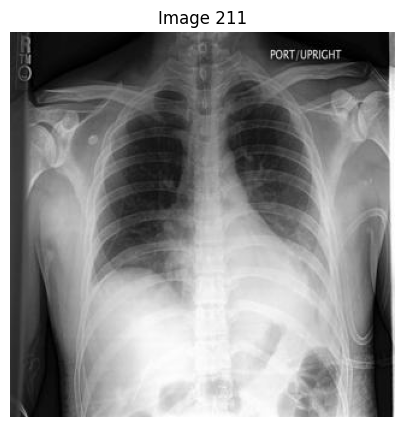

100%|██████████| 1000/1000 [00:39<00:00, 25.15it/s]


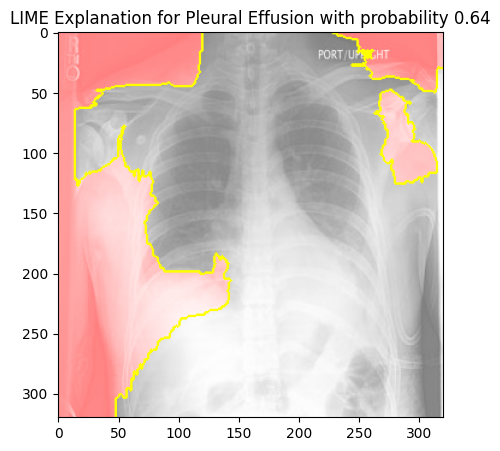

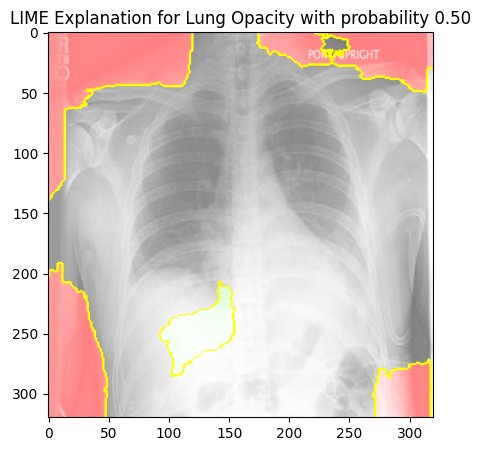

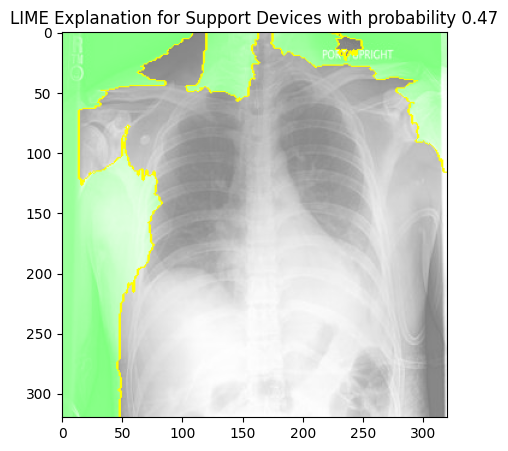

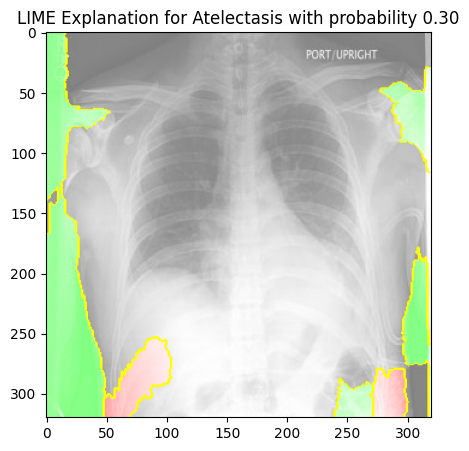

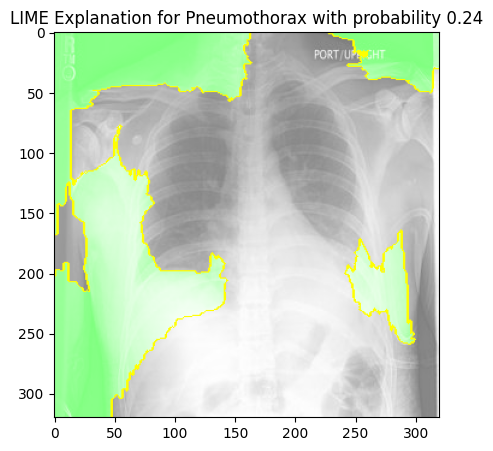

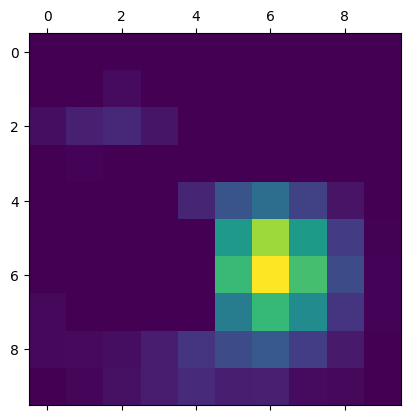

Top Predictions from Grad-CAM:
Pathology                 Probability
Pleural Effusion          0.64
Lung Opacity              0.50
Support Devices           0.47
Atelectasis               0.30
Pneumothorax              0.24


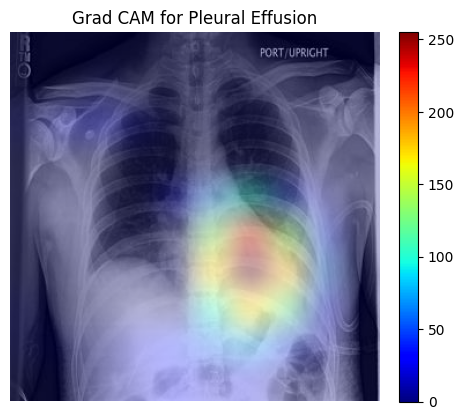

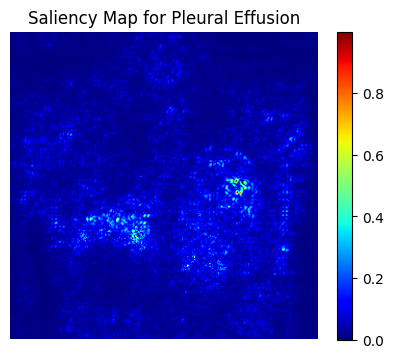

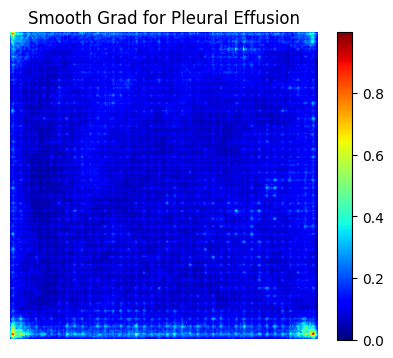

True labels for image 278:
Atelectasis
Pleural Effusion
Enlarged Cardiomediastinum
Lung Opacity

Top 5 Predictions:
Pathology                 Probability
Support Devices           0.35
Pneumothorax              0.28
No Finding                0.27
Lung Opacity              0.22
Atelectasis               0.12


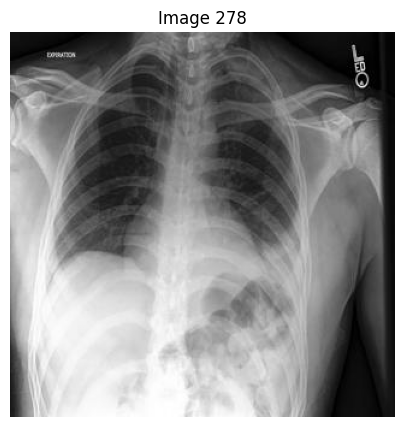

100%|██████████| 1000/1000 [00:40<00:00, 24.78it/s]


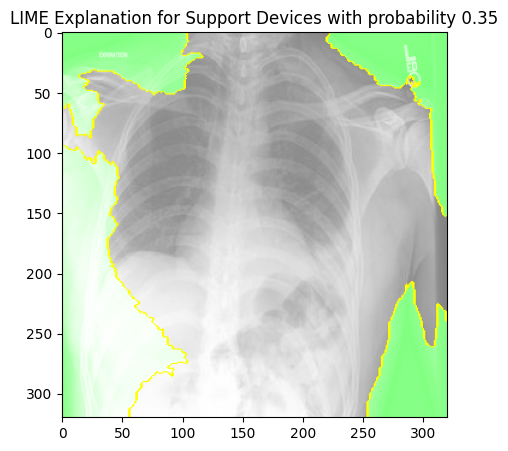

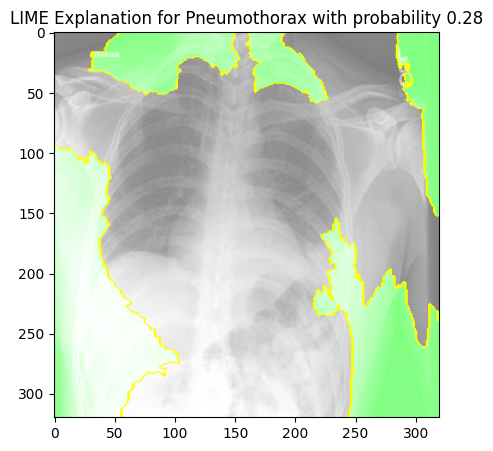

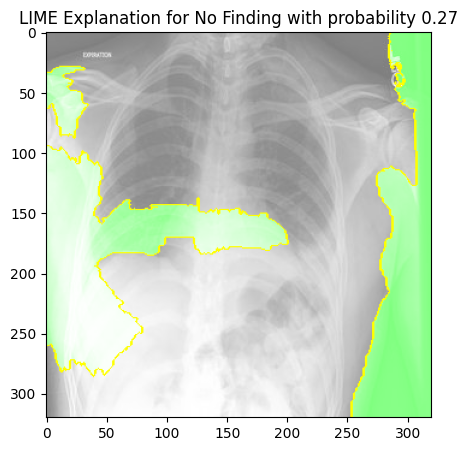

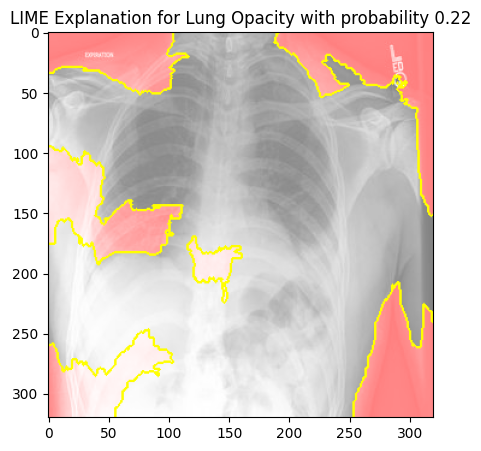

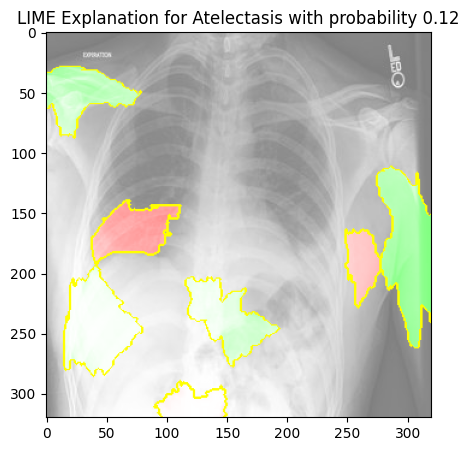

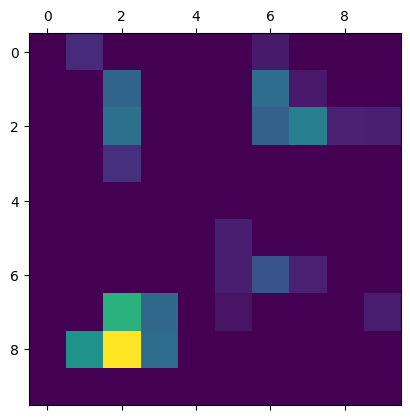

Top Predictions from Grad-CAM:
Pathology                 Probability
Support Devices           0.35
Pneumothorax              0.28
No Finding                0.27
Lung Opacity              0.22
Atelectasis               0.12


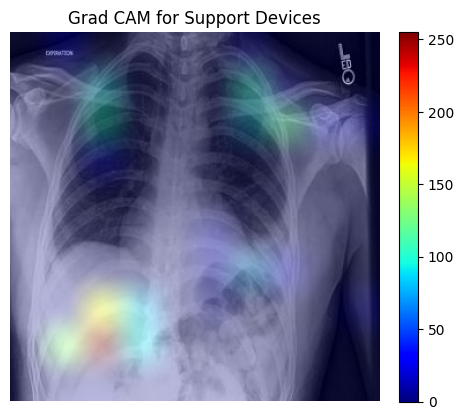

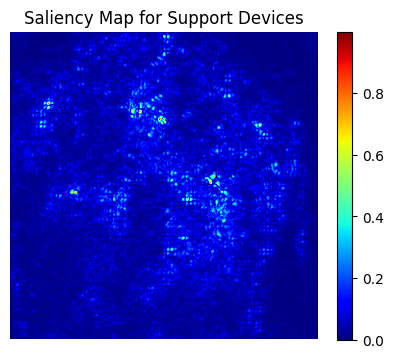

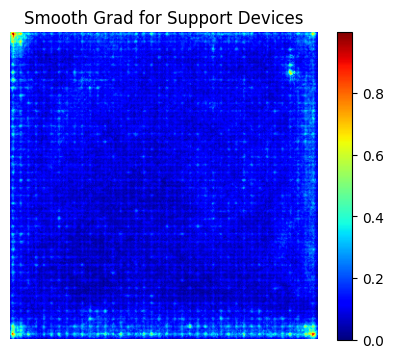

In [49]:
image_indices = [211, 278 ]

if not os.path.exists('xai'):
        os.makedirs('xai')

for index in image_indices:
    image = all_test_images[index]
    img_array = np.array([image])

    # Print true labels
    true_labels(index, all_test_labels, all_pathology)
    print("")

    # Print top 5 predictions
    top5_predictions(image, best_model, all_pathology)

    # Display the image
    plt.figure(figsize=(5,5))
    plt.imshow(image, cmap='gray')
    plt.title(f"Image {index}")
    plt.axis('off')
    plt.savefig(f'xai/{index}_{approach}.png')
    plt.show()

    # LIME Analysis
    lime(image, index, model_predict, best_model, all_pathology, approach)

    # Grad-CAM Analysis
    heatmap, predictions, top_pred_index = make_gradcam_heatmap(img_array, best_model, last_conv_layer_name)
    display_heatmap(heatmap, predictions, all_pathology)
    display_gradcam(image, index, heatmap, top_pred_index)

    # Saliency Map
    saliency_map(image, index, best_model, all_pathology, approach)

    # Smooth Grad
    smooth_grad(image, index, best_model, all_pathology, approach)
